# SYDE 556/750 --- Assignment 5

## Due Date: Dec 2, 2022

**Student ID: 20709541**

_Note:_ Please include your numerical student ID only, do _not_ include your name.

_Note:_ Unlike assignments 1-4, for this assignment the full instructions (including some hints) are in this file. The cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

- This assignment is worth 30 marks (30% of the final grade). The number of marks for each question is indicated in brackets to the left of each question.

- Clearly label any plot you produce, including the axes. Provide a legend if there are multiple lines in the same plot.

- You won’t be judged on the quality of your code.

- All questions use the nengo default of Leaky Integrate-and-Fire neurons with the default parameter settings (`tau_rc=0.02` and `tau_ref=0.002`).

- Make sure to execute the Jupyter command “Restart Kernel and Run All Cells” before submitting your solutions. You will lose marks if your code fails to run or produces results that differ significantly from what you’ve submitted.

- Rename the completed notebook to `syde556_assignment_05_<STUDENT ID>.ipynb` and submit it via email to the TA (Nicole Dumont <ns2dumont@uwaterloo.ca>). The deadline is at 23:59 EST on Dec 2, 2022.

- There is a late penalty of one mark per day late. Please contact celiasmith@uwaterloo.ca if there are extenuating circumstances.

- **For this assignment, you must use [Nengo](https://www.nengo.ai/getting-started/).** Feel free to look through the examples folder and/or the tutorials on the Nengo website before doing this assignment.


In [1]:
# Import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

import nengo

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Building an Accumulate-to-Threshold Decision Making Model

One standard account for how brains make simple decision-making tasks is that they gradually accumulate evidence for or against something, and when that evidence hits some threshold, a decision is made. This sort of model is used to account for the fact that people take longer to make decisions when the evidence is weak.

If you want more background on this, https://www.jneurosci.org/content/34/42/13870 gives a decent overview, but this diagram shows a high-level overview:

![](https://www.jneurosci.org/content/jneuro/34/42/13870/F1.large.jpg)

We're going to make a model of this process. It will make its choice based on a single input value, which gives some evidence as to which choice should be made. It will indicate a choice by outputting either a 1 or a -1. If that input evidence is positive, it will be more likely to make the first choice (outputting a 1), and if the input evidence is negative it will be more likely to make the second choice (outputting a -1).

_TIP: The Nengo GUI built-in tutorials 10 through 18 may be useful to give you an overview of different recurrent systems and different ways of modifying `Ensembles`._


**a) Accumulation. [2 marks]** Start by building a recurrent system that can add up evidence over time (the accumulator or integrator). This is a neural `Ensemble` that holds a single dimension, and uses a small number of neurons (50). Provide it with one input `Node` that has a constant value of `[0.1]` and connect that input into the `Ensemble` with a `Connection`. Now make a `Connection` from the `Ensemble` back to itself that computes the identity function. Since this `Connection` is accumulating evidence over time, we want it to be fairly stable, so set `synapse=0.1` on this `Connection` (leave the other `Connection` at its default value). This means that the neurotransmitter being used will spread out over 100ms, rather than the default 5ms.

If you run the above system with the constant positive input of 0.1 as noted above, the value stored in the accumulator should gradually increase until it hits 1 (this should take about 1 second of simulated time). If you change the input to be -0.1, it should gradually decrease until it hits -1.

Make a single plot that shows the behaviour of the model for four different inputs: 0.2, 0.1, -0.1, and -0.2. For each input, run the model for 2 seconds (`sim.run(2)`) and plot the value stored in the accumulator `Ensemble`. Use a `Probe` synapse of 0.01 to get the stored value.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

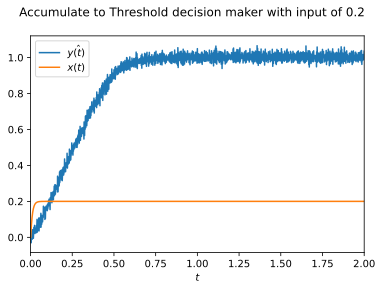

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

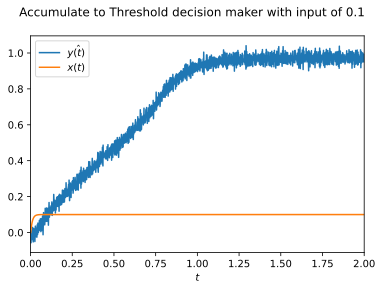

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

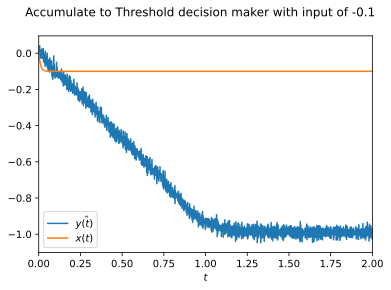

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

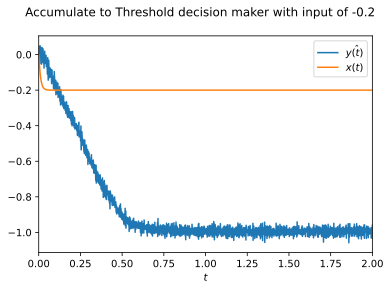

In [2]:
def simulate(
    input=lambda t: 0.1 if t >= 0 else 0,
    run_time=2,
    title="",
    n_neurons=50,
    label="",
    recur_synapse=1 / 10,
    con_synapse=1 / 10,
    probe_synapse=10 / 1000,
    dt=1000,
    noise=None,
    function=None,
    intercepts=None,
):
    model = nengo.Network(label=label)
    dimensions = 1

    def recur(f):
        return 1 * f

    if function == None:
        function = recur

    output = None

    with model:
        x = nengo.Node(input)
        ensemble = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions)

        nengo.Connection(x, ensemble)
        nengo.Connection(ensemble, ensemble, function=recur, synapse=recur_synapse)

        if function != None:
            ensemble2 = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions)
            if intercepts:
                ensemble2.intercepts = intercepts
            nengo.Connection(
                ensemble, ensemble2, function=function, synapse=con_synapse
            )

        probe_x = nengo.Probe(x, synapse=probe_synapse)
        probe_ensemble = nengo.Probe(ensemble, synapse=probe_synapse)
        probe_ensemble2 = None
        if function != None:
            probe_ensemble2 = nengo.Probe(ensemble2, synapse=probe_synapse)
        if noise:
            ensemble.noise = noise

    simulation = nengo.Simulator(model)

    simulation.run(run_time)

    t = simulation.trange()

    output = simulation.data[probe_ensemble]
    if function != None:
        output = simulation.data[probe_ensemble2]

    plt.figure()
    plt.suptitle(title)
    b = plt.plot(t, output, label="$\hat{y(t)}$")
    a = plt.plot(t, simulation.data[probe_x], label="$x(t)$")
    plt.legend(
        handles=[
            a,
            b,
        ],
        labels=[],
    )
    plt.xlim([0, run_time])
    plt.xlabel("$t$")
    plt.show()


simulate(
    input=lambda t: 0.2 if t >= 0 else 0,
    title="Accumulate to Threshold decision maker with input of 0.2",
)
simulate(
    input=lambda t: 0.1 if t >= 0 else 0,
    title="Accumulate to Threshold decision maker with input of 0.1",
)
simulate(
    input=lambda t: -0.1 if t >= 0 else 0,
    title="Accumulate to Threshold decision maker with input of -0.1",
)
simulate(
    input=lambda t: -0.2 if t >= 0 else 0,
    title="Accumulate to Threshold decision maker with input of -0.2",
)

**b) Accumulator Discussion. [1 mark]** What is the mathematical computation being performed here (i.e. what is the relationship between the input and the output)? Why does the value stop increasing (or decreasing) when it hits +1 (or -1)?


There is a linear relationship between the input and the output. That is, for every time step the the output $\hat{y_{t+1}} = \hat{y_t} + \hat{x_t}$ where $\hat{y_0}=0$ where $t=0,1,2...$ are the timesteps. This results in a linear accumulation at each timestep by the initial input. This is why it takes half the time for twice the input to reach the saturation point of the Accumulate-to-threshold model. The reason why the model does not represent values $|x| \gt 1$ is because encoders limited to values between -1 and 1. This means that the populations cannot encode or "represent" values whos magnitudes extend beyond -1 and 1.


**c) Adding random noise to the neurons. [1 mark]** Next, we can add randomness to the neurons. In standard (non-neural) accumulator models, there is a "random-walk" component that randomly varies the value being accumulated. We can model this by adding random noise into the `Ensemble`, which means adding random current to each of the neurons. The command for this is:

```python
acc.noise = nengo.processes.WhiteSignal(period=10, high=100, rms=1)
```

(where `acc` is whatever name you gave your accumulator `Ensemble`.)

The strength of this noise is set by the `rms=1` parameter. Generate the same plot as in part (a) but with the noise `rms=1`. Also generate the same plot for `rms=3`, `rms=5`, and `rms=10`. What happens to the resulting output?


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

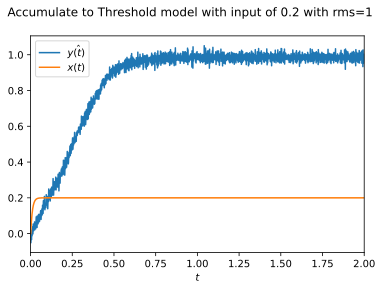

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

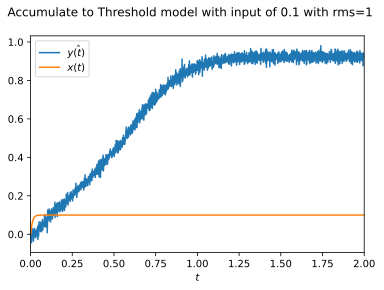

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

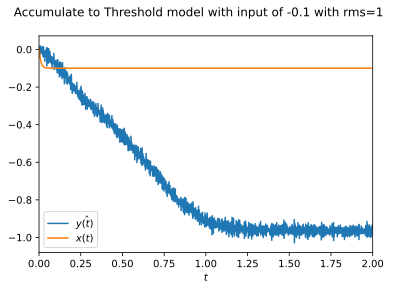

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

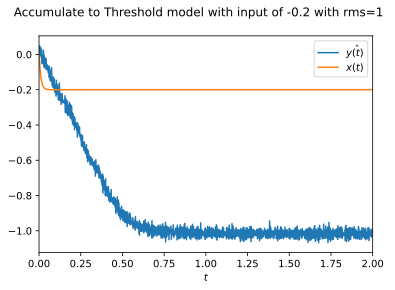

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

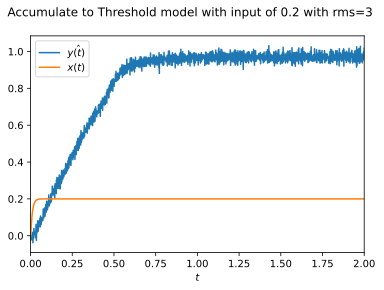

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

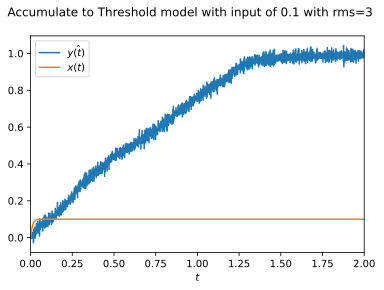

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

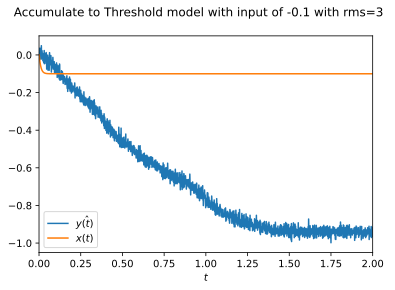

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

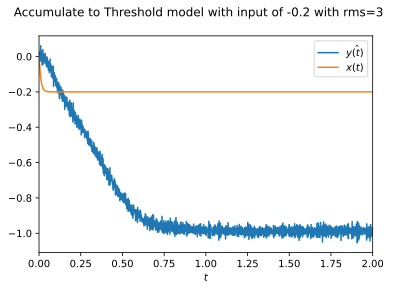

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

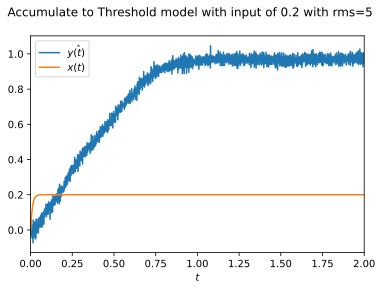

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

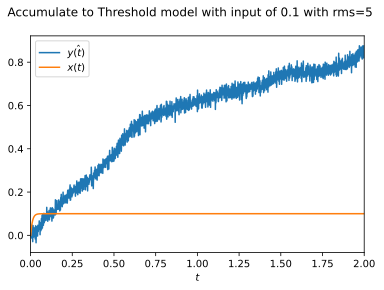

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

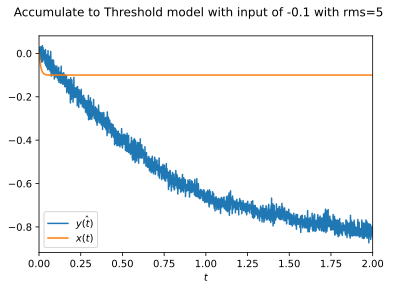

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

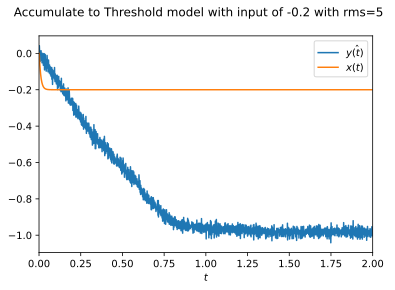

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

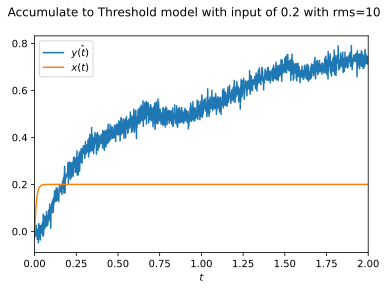

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

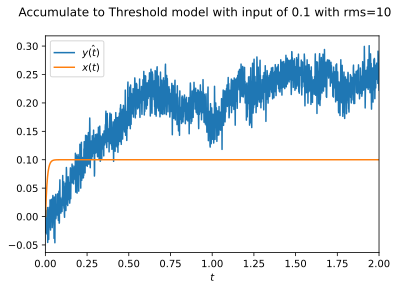

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

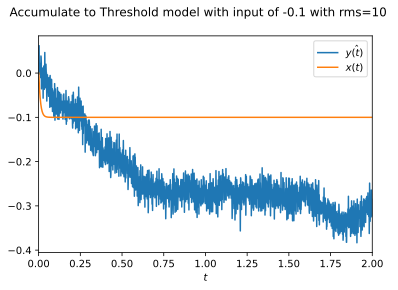

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

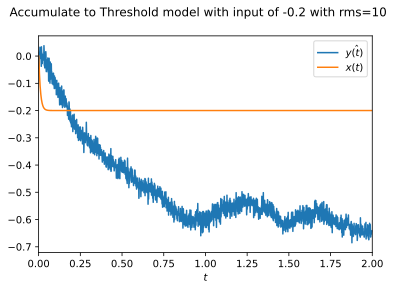

In [3]:
rms_s = [1, 3, 5, 10]
inputs = [
    {"f": lambda t: 0.2 if t >= 0 else 0, "l": "0.2"},
    {"f": lambda t: 0.1 if t >= 0 else 0, "l": "0.1"},
    {"f": lambda t: -0.1 if t >= 0 else 0, "l": "-0.1"},
    {"f": lambda t: -0.2 if t >= 0 else 0, "l": "-0.2"},
]
for rms in rms_s:
    noise = nengo.processes.WhiteSignal(period=10, high=100, rms=rms)
    for input in inputs:
        title = (
            "Accumulate to Threshold model with input of "
            + input["l"]
            + " with rms="
            + str(rms)
            + " "
        )
        simulate(input=input["f"], noise=noise, title=title)

As we can see, when we increase the RMS in the noise signal, the model performs significantly worse and does not saturate as quickly. This is due to the heavy presense of noise in the signal and behaves as we would expect. That is: as the error in the signal increases the performace decreases.


**e) Adding decision-making. [2 marks]** To complete the basic model, we want to determine when this accumulator passes some threshold. If the value becomes large enough, we should make one choice (+1), and if it becomes small enough we should make the other choice (-1). To achieve this, make a new output `Ensemble` that is also one-dimensional and has 50 neurons. Form a `Connection` from the accumulator to this new `Ensemble` that computes the following function:

```python
def choice(x):
    if x[0] > 0.9:
        return 1
    elif x[0] < -0.9:
        return -1
    else:
        return 0
```

This new output should now stay at zero until the accumulator value gets large enough, and then quickly move to +1 or -1.

Build this model and plot the output of both the accumulator `Ensemble` and the decision-making `Ensemble`. Use a noise `rms=3` and for both `Probe`s use a synapse of 0.01. Do this for all four input values (0.2, 0.1, -0.1, and -0.2).

How well does the system perform? Does it make decisions faster when there is stronger evidence? What differences are there (if any) between the computation we are asking the system to perform and the actual result?

_TIP: try running the model a few times to see the variability in the output_


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

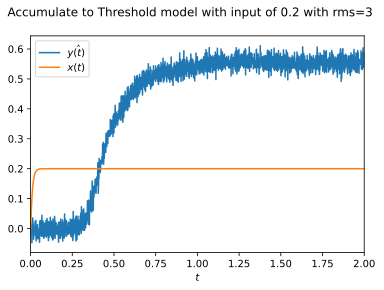

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

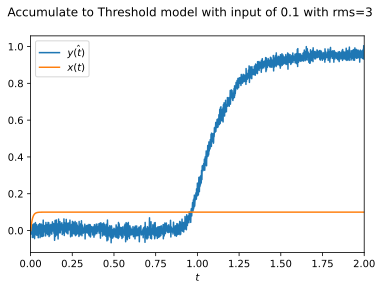

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

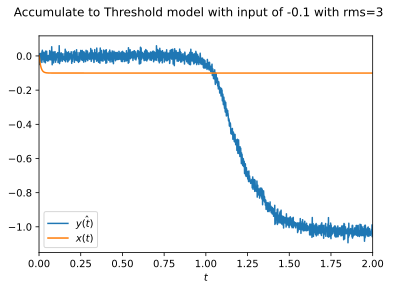

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

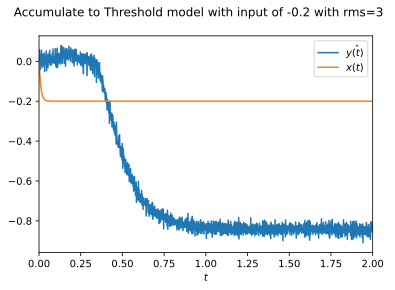

In [4]:
# decision maker
def choice(x):
    if x[0] > 0.9:
        return 1
    elif x[0] < -0.9:
        return -1
    else:
        return 0


inputs = [
    {"f": lambda t: 0.2 if t >= 0 else 0, "l": "0.2"},
    {"f": lambda t: 0.1 if t >= 0 else 0, "l": "0.1"},
    {"f": lambda t: -0.1 if t >= 0 else 0, "l": "-0.1"},
    {"f": lambda t: -0.2 if t >= 0 else 0, "l": "-0.2"},
]

rms = 3
noise = nengo.processes.WhiteSignal(period=10, high=100, rms=rms)
for input in inputs:
    title = (
        "Accumulate to Threshold model with input of "
        + input["l"]
        + " with rms="
        + str(rms)
        + " "
    )
    simulate(input=input["f"], noise=noise, title=title, function=choice)

As we would expect, the model reaches a decision much quicker with the `choice` model as it is only considering strong evidence in it's decision causing it to reach the threshold and saturate much quicker.


**f) Combining Ensembles. [2 marks]** An alternative implementation would be to combine the two separate 1-dimensional `Ensembles` into one 2-dimensional `Ensemble`. The Connections are made similarly as in the original model, but they need to target the particular dimensions involved using the `ens[0]` and `ens[1]` syntax. Try building the model this way and plot the results. Do this for a single `Ensemble` with 100 neurons (the same number as the total number of neurons in the original model) and with 500 neurons. Also, be sure to increase the `radius` as would be appropriate in order to produce values like what we had in the original model, where the accumulator might be storing a 1 and the output might be a 1.

How does combining Ensembles in this way change the performance of the system?

When the Ensembles are combined together in this way, what are we changing about the biological claims about the model? In particular, how might we determine whether the real biologicial system has these as separate `Ensembles` or combined together?


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

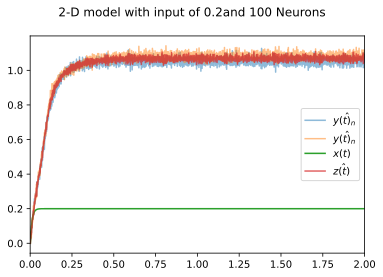

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

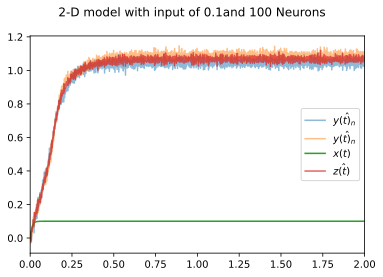

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

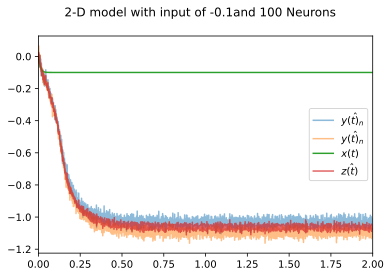

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

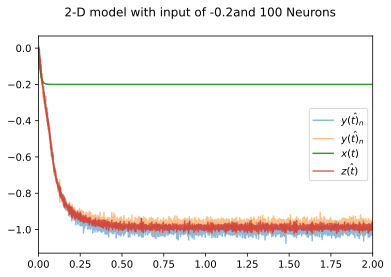

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

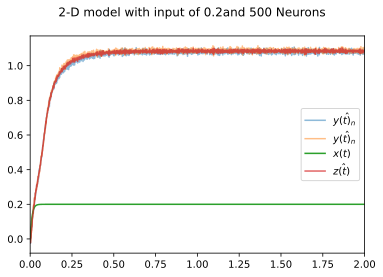

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

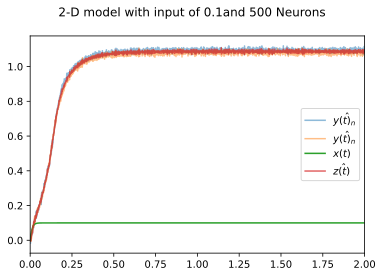

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

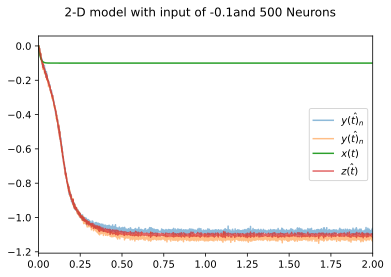

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

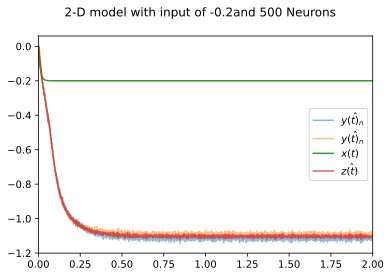

In [5]:
def simulate_combination(
    input=lambda t: 0.1 if t >= 0 else 0,
    run_time=2,
    title="",
    n_neurons=100,
    label="",
    recur_synapse=1 / 10,
    probe_synapse=10 / 1000,
    dt=1000,
    noise=None,
    function=None,
):
    model = nengo.Network(label=label)
    dimensions = 2

    def recur(f):
        return [f[0] + f[1], f[0] + f[1]]

    # return f+f

    if function == None:
        function = recur

    with model:
        x = nengo.Node(input)
        ensemble = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions, radius=1)
        nengo.Connection(x, ensemble[0])
        nengo.Connection(x, ensemble[1])
        nengo.Connection(ensemble, ensemble, function=recur, synapse=recur_synapse)

        probe_x = nengo.Probe(x, synapse=probe_synapse)
        probe_ensemble = nengo.Probe(ensemble, synapse=probe_synapse)

        if noise:
            ensemble.noise = noise

    simulation = nengo.Simulator(model)

    simulation.run(run_time)

    t = simulation.trange()

    output = [(x[0] + x[1]) / 2 for x in simulation.data[probe_ensemble]]

    plt.figure()
    plt.suptitle(title)
    b = plt.plot(
        t, simulation.data[probe_ensemble], label="$\hat{y(t)_{n}}$", alpha=0.5
    )
    a = plt.plot(t, simulation.data[probe_x], label="$x(t)$")
    c = plt.plot(t, output, label="$\hat{z(t)}$", alpha=0.7)
    plt.legend(
        handles=[a, b],
        labels=[],
    )
    plt.xlim([0, run_time])
    plt.show()


inputs = [
    {"f": lambda t: 0.2 if t >= 0 else 0, "l": "0.2"},
    {"f": lambda t: 0.1 if t >= 0 else 0, "l": "0.1"},
    {"f": lambda t: -0.1 if t >= 0 else 0, "l": "-0.1"},
    {"f": lambda t: -0.2 if t >= 0 else 0, "l": "-0.2"},
]

neuron_count = [100, 500]

for neurons in neuron_count:

    for input in inputs:
        simulate_combination(
            input=input["f"],
            title="2-D model with input of "
            + input["l"]
            + "and "
            + str(neurons)
            + " Neurons",
            n_neurons=neurons,
        )

When we change the models dimensions we are biologically stating that the model accumulates decisions based on different dimentions of information, such as direction and speed (for example) to make a decision. This likely closer to what biologically takes place. The model performance remains somewhat the same as in previous implementation approaches.


**g) Improving Representation [2 marks].** Returning to the original implementation from section (e) (with 2 separate Ensembles), we can improve the performance by adjusting the tuning curves of the second `Ensemble`. Do this by setting `intercepts = nengo.dists.Uniform(0.4, 0.9)`. This randomly chooses the x-intercepts of the neurons uniformly between 0.4 and 0.9, rather than the default of -1 to 1. Generate the same plot as in part (e).

How does this affect the performance of the model? (Try running the model a few times to see the variability in performance).

Why does the output stay at exactly zero up until the decision is made (rather than being randomly jittering around zero, as in the previous models)?

Why couldn't we use this approach in the case from part (f) where the `Ensembles` are combined?


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

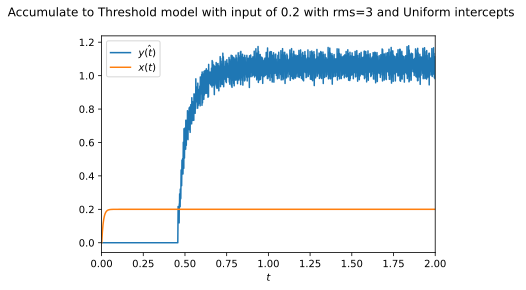

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

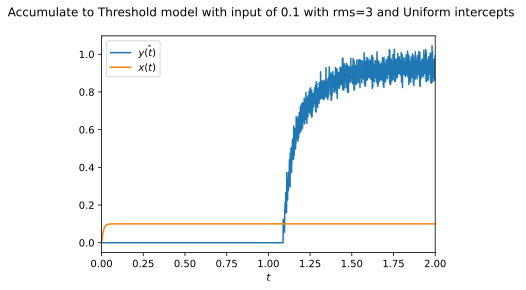

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

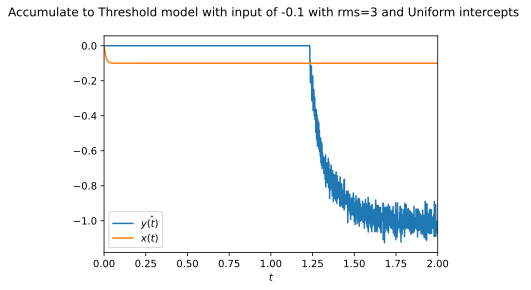

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

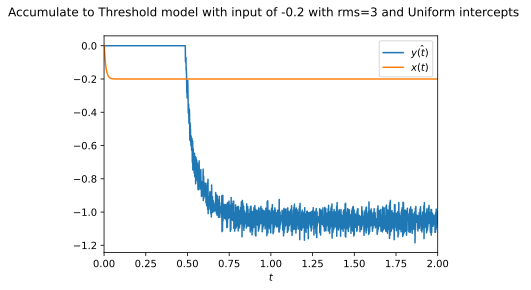

In [6]:
# decision maker
def choice(x):
    if x[0] > 0.9:
        return 1
    elif x[0] < -0.9:
        return -1
    else:
        return 0


inputs = [
    {"f": lambda t: 0.2 if t >= 0 else 0, "l": "0.2"},
    {"f": lambda t: 0.1 if t >= 0 else 0, "l": "0.1"},
    {"f": lambda t: -0.1 if t >= 0 else 0, "l": "-0.1"},
    {"f": lambda t: -0.2 if t >= 0 else 0, "l": "-0.2"},
]

rms = 3
noise = nengo.processes.WhiteSignal(period=10, high=100, rms=rms)
intercepts = nengo.dists.Uniform(0.4, 0.9)
for input in inputs:
    title = (
        "Accumulate to Threshold model with input of "
        + input["l"]
        + " with rms="
        + str(rms)
        + " and Uniform intercepts "
    )
    simulate(
        input=input["f"],
        noise=noise,
        title=title,
        function=choice,
        intercepts=intercepts,
    )

**REVISIT**
The model appears to perform much better than in (e). The output does not jitter because the intercepts are uniformly distributed between 0.4 and 0.9 meaning. Because of the normal distribution of the values, the second approach would not work


# 2. Temporal Representation

In class, we discussed the Legendre Memory Unit (LMU), a method for storing input information over time. This allows us to make connections where the function being computed is a function of the input over some window in time, rather having to be a function of the current input.

In this question, we will use this to build a model that can distinguish a 1Hz sine wave from a 2Hz sine wave. Notice that it is impossible to perform this task without having information over time; if I just give you a single number at any given point in time, you can't tell whether it's from a 1Hz sine wave or a 2Hz sine wave. So we need some method to store the previous input information, and that's what the LMU does.


**a) Representing Information over Time. [2 marks]** The core of the LMU is to compute the differential equation ${dx \over dt} = Ax + Bu$ where $A$ and $B$ are carefully chosen using the following math:

```python
A = np.zeros((q, q))
B = np.zeros((q, 1))
for i in range(q):
    B[i] = (-1.)**i * (2*i+1)
    for j in range(q):
        A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1))
A = A / theta
B = B / theta
```

Implement this in Nengo. Use `theta=0.5` and `q=6`. The model should consist of a single `Ensemble` that is `q`-dimensional. Use 1000 neurons in this `Ensemble`. Use `synapse=0.1` on both the recurrent `Connection` and on the input `Connection`.

For the input, give a 1Hz sine wave for the first 2 seconds, and a 2Hz sine wave for the second 2 seconds. This can be done with:

```python
stim = nengo.Node(lambda t: np.sin(2*np.pi*t) if t<2 else np.sin(2*np.pi*t*2))
```

Run the simulation for 4 seconds. Plot `x` over the 4 seconds using a `Probe` with `synapse=0.01`. `x` should be 6-dimensional, and there should be a noticable change between its value before `t=2` and after `t=2`.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

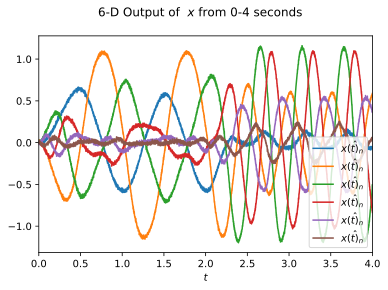

In [7]:
def nef_lti(q=6, theta=0.5, synapse=1 / 10):
    A = np.zeros((q, q))
    B = np.zeros((q, 1))
    for i in range(q):
        B[i] = (-1.0) ** i * (2 * i + 1)
        for j in range(q):
            A[i, j] = (2 * i + 1) * (-1 if i < j else (-1.0) ** (i - j + 1))
    A = A / theta
    B = B / theta
    Ap = synapse * A + np.eye(A.shape[0])
    Bp = synapse * B
    return A, B, Ap, Bp


def make_target(shape=(4000, 1), change=2000, first_decision=1, second_decision=-1):
    target = np.ones(shape) * first_decision
    for i in range(change):
        target[change + i][0] = second_decision
    return target


def rmse(x1, x2):
    return np.sqrt(np.mean(np.power(x1 - x2, 2)))


def simulate_lmu(
    input=lambda t: np.sin(2 * np.pi * t) if t < 2 else np.sin(2 * np.pi * t * 2),
    run_time=4,
    title="",
    n_neurons=1000,
    label="",
    recur_synapse=1 / 10,
    probe_synapse=10 / 1000,
    q=6,
    theta=0.5,
    compute=False,
    calc_rmse=False,
    target=make_target(),
    dt=1000,
    eval_points=[],
):
    model = nengo.Network(label=label)
    _, _, Ap, Bp = nef_lti(q=q, theta=theta, synapse=recur_synapse)

    with model:
        stim = nengo.Node(input)
        lmu = nengo.Ensemble(n_neurons=n_neurons, dimensions=q)
        nengo.Connection(stim, lmu, transform=Bp, synapse=recur_synapse)
        nengo.Connection(lmu, lmu, synapse=recur_synapse, transform=Ap)
        probe_lmu = nengo.Probe(lmu, synapse=probe_synapse)

    simulation = nengo.Simulator(model)
    simulation.run(run_time)

    t = simulation.trange()

    if len(eval_points) == 0:
        eval_points = simulation.data[probe_lmu]

    if compute == False:
        plt.figure()
        plt.suptitle(title)
        b = plt.plot(t, simulation.data[probe_lmu], label="$\hat{x(t)_{n}}$")
        plt.legend(
            handles=[b],
            labels=[],
        )
        plt.xlim([0, run_time])
        plt.xlabel("$t$")
        plt.show()

    error = 0
    if compute == True:
        _, _, Ap, Bp = nef_lti(q=q, theta=theta, synapse=recur_synapse)
        with model:
            computer = nengo.Ensemble(n_neurons=50, dimensions=1)
            stim = nengo.Node(input)
            lmu = nengo.Ensemble(n_neurons=n_neurons, dimensions=q)
            nengo.Connection(stim, lmu, transform=Bp, synapse=recur_synapse)
            nengo.Connection(lmu, lmu, synapse=recur_synapse, transform=Ap)
            nengo.Connection(lmu, computer, eval_points=eval_points, function=target)
            probe_lmu = nengo.Probe(lmu, synapse=probe_synapse)
            probe_computer = nengo.Probe(computer, synapse=probe_synapse)

        simulation = nengo.Simulator(model)
        simulation.run(run_time)
        t = simulation.trange()
        signal = [input(p) for p in np.linspace(0, run_time, run_time * dt)]
        computed = simulation.data[probe_computer]
        plt.figure()
        plt.suptitle(title)
        b = plt.plot(t, computed, label="$\hat{y(t)}$")
        c = plt.plot(t, signal, label="Input", alpha=0.5)
        plt.legend(
            handles=[
                b,
                c,
            ],
            labels=[],
        )
        plt.xlim([0, run_time])
        plt.xlabel("$t$")
        plt.show()

        if calc_rmse:
            error = rmse(computed, target)

    simulation.close()
    return eval_points, error


eval_points, _ = simulate_lmu(title="6-D Output of  $x$ from 0-4 seconds")

**b) Computing the function. [2 marks]** We now want to compute our desired function, which is "output a 1 if we have a 1Hz sine wave and a 0 if we have a 2Hz sine wave". To do this, we need to make a `Connection` from the LMU `Ensemble` out to a new `Ensemble` that will be our category. Have it be 1-dimensional with 50 neurons.

Normally in Nengo, when we define a `Connection` we specify a Python function that we want to approximate. Nengo will then choose a bunch of random `x` values, call the function to determine what the output should be for each one, and use that to solve for the decoders. However, in this case, we already have that set of `x` values! That's exactly the data you plotted in part (a). For the `x` values from t=0 to t=2.0 we want an output of 1. For the `x` values from t=2.0 to t=4.0, we want an output of -1. So, to specify these target values, we make a matrix of size `(4000,1)` (4000 for the 4000 time steps that you have `x` values for, and 1 for the output being 1-dimensional). Set the first 2000 values to 1 and the second 2000 values to -1.

Now that you have your `x` values and the corresponding `target` values, you can tell Nengo to use them when you make the `Connection` like this:

```python
nengo.Connection(a, b, eval_points=x_values, function=target)
```

That will tell Nengo just to use the values you're giving it, rather than randomly sampling `x` and calling a function to get the target values.

Build this model and plot the resulting category (with a `Probe` with `synapse=0.01`). The output should be near 1 for the first 2 seconds, and near -1 for the second 2 seconds. (Important note: it will not be perfect at this task!)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

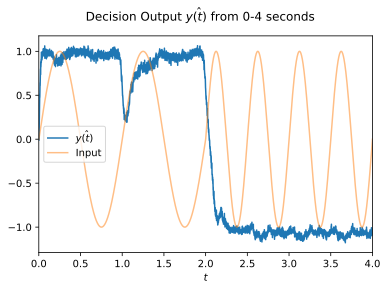

In [8]:
_, _ = simulate_lmu(
    compute=True,
    eval_points=eval_points,
    title="Decision Output $\hat{y(t)}$ from 0-4 seconds",
)

**c) Adjusting the input. [2 marks]** Repeat part b) but with an input that is a 2Hz sine wave for the first 2 seconds, and a 1Hz sine wave for the second 2 seconds (i.e. the opposite order as in part (b)). How well does this perform? Describe the similarities and differences. One particular difference you should notice is that the model may make the wrong classification for the first 0.25 seconds. Why is this happening? What could you change to fix this?


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

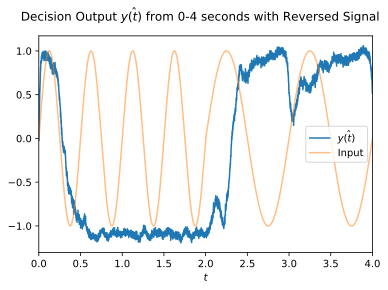

In [9]:
input = lambda t: np.sin(2 * np.pi * t * 2) if t < 2 else np.sin(2 * np.pi * t)
_, _ = simulate_lmu(
    input=input,
    compute=True,
    eval_points=eval_points,
    title="Decision Output $\hat{y(t)}$ from 0-4 seconds with Reversed Signal",
)

As expected, the model is incorrect for the first ~0.25 seconds. This is because the model was previouly trained with a different signal. If you were to re-train the model with the correct evaluation points you would see this incorrect classification error got to 0. You could also add a decision delay to the system so that the model would accumulate evidence before making a decision classification. This would also reduce the error. The draw-back to this approach however is that the decision classification is delayed and is not "real-time" i.e the model would be making a decision on the accumulation of previous signal data.


**d) Adjusting the number of neurons. [2 marks]** Repeat part b) but adjust the number of neurons in the `Ensemble` computing the differential equation. Try 50, 100, 200, 500, 1000, 2000, and 5000. How does the model behaviour change? Why does this happen? In addition to looking at the actual results for each run, also plot the RMSE in the classification as you adjust the number of neurons.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

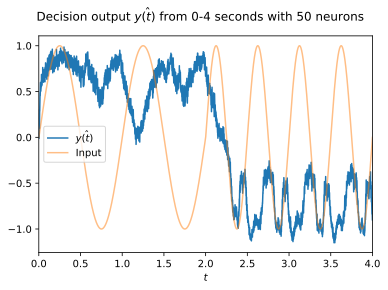

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

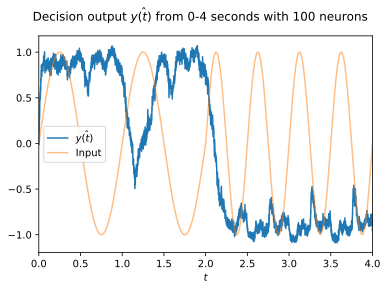

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

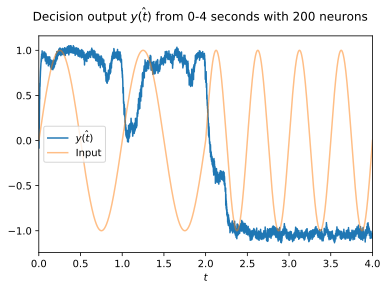

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

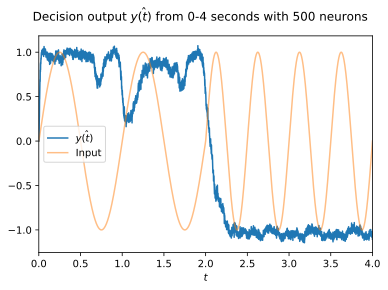

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

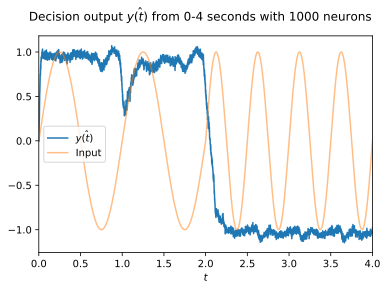

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

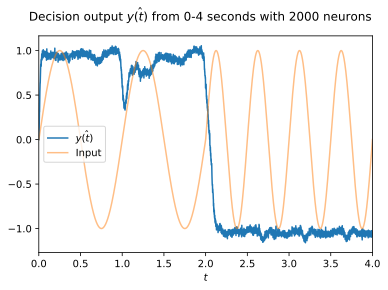

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

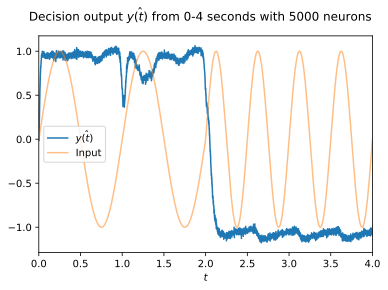

In [10]:
neuron_counts = [50, 100, 200, 500, 1000, 2000, 5000]
rmses = []
for count in neuron_counts:
    _, error = simulate_lmu(
        compute=True,
        eval_points=eval_points,
        n_neurons=count,
        calc_rmse=True,
        title="Decision output $\hat{y(t)}$ from 0-4 seconds with "
        + str(count)
        + " neurons",
    )
    rmses.append({"rmse": error, "neurons": count})

RMSE =============================================
Neurons: 50 ...... RMSE: 0.4974489155362161
Neurons: 100 ...... RMSE: 0.4102463872299571
Neurons: 200 ...... RMSE: 0.30032267367099086
Neurons: 500 ...... RMSE: 0.2629735026527043
Neurons: 1000 ...... RMSE: 0.21785662731491923
Neurons: 2000 ...... RMSE: 0.20689242465208216
Neurons: 5000 ...... RMSE: 0.20147190804589382


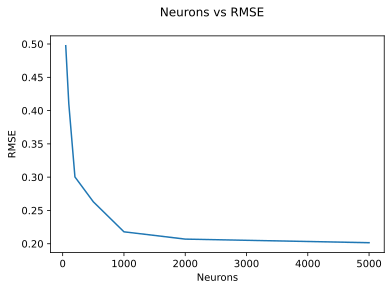

In [11]:
n = []
err = []
print("RMSE =============================================")
for e in rmses:
    print("Neurons: " + str(e["neurons"]) + " ...... RMSE: " + str(e["rmse"]))
    n.append(e["neurons"])
    err.append(e["rmse"])
print("==================================================")

plt.suptitle("Neurons vs RMSE")
plt.plot(n, err)
plt.xlabel("Neurons")
plt.ylabel("RMSE")
plt.show()

We can see that as we add more neurons the performance of the model improves with respect to it's accurancy. It does however, take significantly longer to run as the number of neurons increase

The above figure shows a decreasing exponential relationship between the number of neurons as the root mean squared error becuase a larger number of neurons means that we can better approximate the function we are attempting to compute.


**e) Adjusting the q value. [2 marks]** Repeat part b) (returning to 1000 neurons) but adjust the value of `q`. Try 1, 2, 4, 8, 16, 32, and 64. How does the model behaviour change? Why does this happen? In addition to looking at the actual results for each run, also plot the RMSE in the classification as you adjust the number of neurons.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

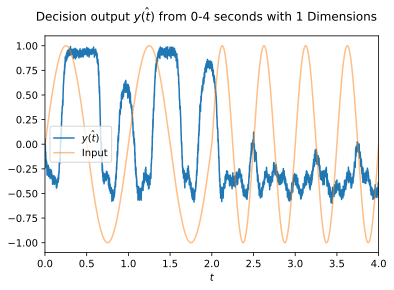

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

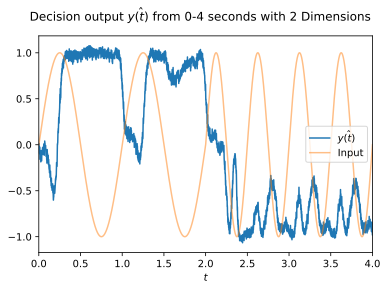

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

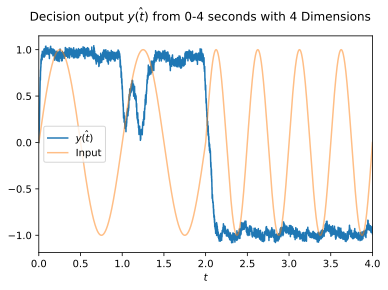

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

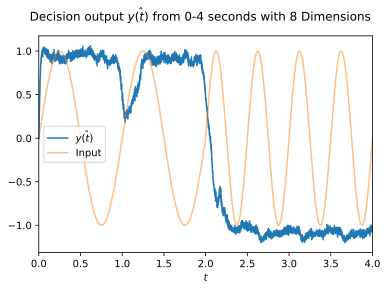

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

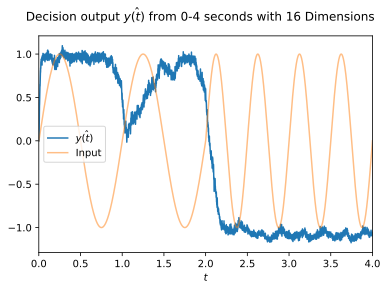

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

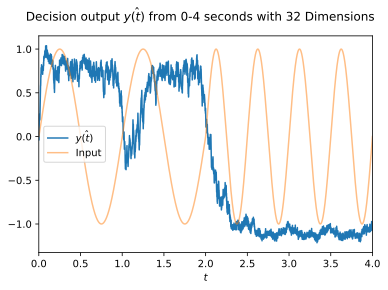

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

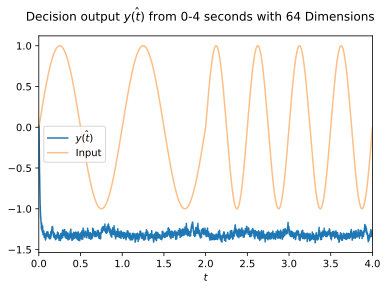

In [12]:
dimensions = [1, 2, 4, 8, 16, 32, 64]
rmses = []
for dim in dimensions:
    _, error = simulate_lmu(
        compute=True,
        q=dim,
        calc_rmse=True,
        title="Decision output $\hat{y(t)}$ from 0-4 seconds with "
        + str(dim)
        + " Dimensions",
    )
    rmses.append({"rmse": error, "dim": dim})

RMSE =============================================
Dimensions: 1 ...... RMSE: 0.8123444627295386
Dimensions: 2 ...... RMSE: 0.5107558689711369
Dimensions: 4 ...... RMSE: 0.25186698945881697
Dimensions: 8 ...... RMSE: 0.2460357177625307
Dimensions: 16 ...... RMSE: 0.28969342695621375
Dimensions: 32 ...... RMSE: 0.37697131580627535
Dimensions: 64 ...... RMSE: 1.644534630147604


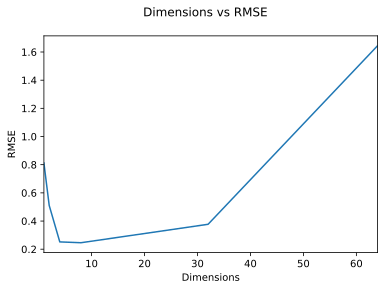

In [13]:
n = []
err = []
print("RMSE =============================================")
for e in rmses:
    print("Dimensions: " + str(e["dim"]) + " ...... RMSE: " + str(e["rmse"]))
    n.append(e["dim"])
    err.append(e["rmse"])
print("==================================================")

plt.suptitle("Dimensions vs RMSE")
plt.plot(n, err)
plt.xlabel("Dimensions")
plt.ylabel("RMSE")
plt.xlim([1, 64])
plt.show()

Based on the findings it appears that as the dimensionality increases beyond 8, the error begins to increase. At first this seems couter-intuitive, however when we consider that there is an increase in the presense of noise with the increse in dimensionality, we can see that higher dimensions result in large amounts of noise, increasing the error. As a result, unlike the case with neurons, an increase in dimensions does not correlate to a decrease in the error.

# 3. Online Learning

Normally when build models with the Neural Engineering Framework, we compute the connection weights at the beginning and then leave them fixed while running the model. But, we can also apply online learning rules to adjust the connection weights over time. This has the effect of changing the function being computed. One general learning rule is the PES rule, where you provide an extra input that indicates whether the output value should be increased or decreased. This is generally called an error signal.

**a) Basic online learning. [2 marks]** Build a network that will learn the identity function. You will need three `Ensembles`, one for the input, one for the output, and one for the error. Each one is 1-dimensional and uses 200 neurons. For the input, use Nengo to randomly generate a 2Hz band-limited white noise signal as follows:

```python
stim = nengo.Node(nengo.processes.WhiteSignal(period=100, high=2, rms=0.3))
```

When making the learning connection, initialize it to compute the zero function and to use the PES learning rule as follows:

```python
def initialization(x):
    return 0
c = nengo.Connection(pre, post, function=initialization, learning_rule_type=nengo.PES(learning_rate=1e-4))
```

The error `Ensemble` should compute the difference between the output value and the desired output value. For this initial question, we want the output value to be the same as the input value (i.e. we are learning the identity function). Then connect the error `Ensemble` to the learning rule as follows:

```python
nengo.Connection(error, c.learning_rule)
```

(Note: for this question, leave the `synapse` values on the `Connections` at their default values)

Run the model for 10 seconds and plot the input value and the resulting output value (using a `Probe` with `synapse=0.01`). The output should match the input fairly well after the first few seconds.


In [14]:
def initialization(x):
    return 0


def identity(x):
    return 1 * x


def learn(
    input=nengo.processes.WhiteSignal(period=100, high=2, rms=0.3),
    run_time=10,
    title="",
    n_neurons=200,
    label="",
    dimensions=1,
    learning_rate=1e-4,
    initialization=initialization,
    function=identity,
    penalty=-1,
    reward=1,
    probe_synapse=10 / 1000,
    plot=True,
):
    model = nengo.Network(label=label)

    with model:
        stim = nengo.Node(input)
        pre = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions)
        post = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions)
        error = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions)
        nengo.Connection(stim, pre)
        c = nengo.Connection(
            pre,
            post,
            function=initialization,
            learning_rule_type=nengo.PES(learning_rate=learning_rate),
        )
        nengo.Connection(stim, error, function=function, transform=penalty)
        nengo.Connection(post, error, transform=reward)
        nengo.Connection(error, c.learning_rule)
        p_stim = nengo.Probe(stim, synapse=probe_synapse)
        p_pre = nengo.Probe(pre, synapse=probe_synapse)
        p_post = nengo.Probe(post, synapse=probe_synapse)
        p_error = nengo.Probe(error, synapse=probe_synapse)

    simulation = nengo.Simulator(model)

    simulation.run(run_time)

    t = simulation.trange()

    input_val = simulation.data[p_stim]
    error_val = simulation.data[p_error]
    pre_val = simulation.data[p_pre]
    post_val = simulation.data[p_post]

    if plot == False:
        return input_val, error_val, pre_val, post_val

    plt.figure()
    plt.suptitle(title)
    aa = plt.plot(t, input_val, label="Input")
    cc = plt.plot(t, post_val, label="Learned Estimate")
    plt.legend(
        handles=[
            aa,
            cc,
        ],
        labels=[],
    )
    plt.xlim([0, run_time])
    plt.show()
    return input_val, error_val, pre_val, post_val

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

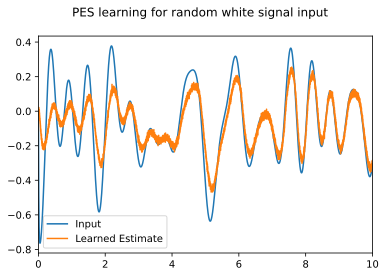

In [15]:
input_val, _, _, post_val = learn(title="PES learning for random white signal input")

**b) Error calculation. [1 mark]** What would happen if you reversed the sign of the error calculation (i.e. if you did `target - output` rather than `output - target`? Why does that happen?


If you subtracted the output from the target value, rather then the target from the output, you would be driving the learning in the wrong direction! That is: rather than approaching the signal as time goes infinity, the model would eventually saturate at either the maximum or minimum radius that the populations could represent, not the function that it is attempting to learn.


**c) Computing metrics. [1 mark]** Break your data up into 2-second chunks and compute the Root-Mean-Squared-Error between the target value (the stimulus itself) and the output from the model for each chunk. Since the simulation is 10 seconds long, you should have 5 RMSE measures (one for the first 2 seconds, one for the second 2 seconds, one for the third 2 seconds, and so on). Repeat the simulation 10 times and plot the average for each of these values. The result should show that the model gets better over time, but does not reach 0 error.


In [27]:
def compute_metrics(run_time=10, attempts=10, slices=5):
    errors = []
    for _ in range(attempts):
        input_val, _, _, post_val = learn(
            title="PES learning for random white signal input",
            plot=False,
            run_time=run_time,
        )
        input = input_val
        output = post_val
        attempt_errors = []

        assert len(input) == len(output)
        length = len(input)
        slice = int(length / slices)

        start = 0
        stop = slice

        for _ in range(slices):
            in_n = input[start:stop]
            out_n = output[start:stop]
            e = rmse(in_n, out_n)
            attempt_errors.append(e)
            temp = stop
            start = stop
            stop = temp + slice
        errors.append(attempt_errors)

    error_matrix = np.array(errors)

    mean_errors = np.mean(error_matrix, axis=0)

    tscale = np.linspace(1, slices, slices)

    plt.figure()
    plt.suptitle(" $\mu$ RMSE for $n$ segments of 10 second signal")
    plt.plot(tscale, mean_errors)
    plt.xlabel("$n$")
    plt.ylabel("RMSE")
    plt.xlim([1, slices])
    plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

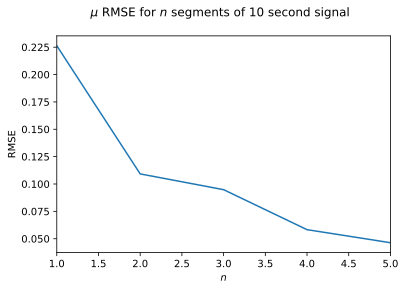

In [28]:
compute_metrics(run_time=10)

**d) Increasing learning time. [2 marks]** Repeat part (c), but run the model for 100 seconds instead of 10 seconds. How do the results change?


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

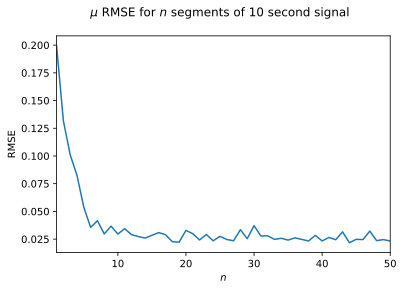

In [29]:
compute_metrics(run_time=100, slices=50)

We can see that as we increase the learning time, the error gets much smaller, but again does not become 0. This is because we hav a lossy system and while learning forever will decrease the RMSE, the error it will eventually approach some minimum possible value at which it will remain relatiely constant. We can also see that as the error decreases, the presense of noise becomes larger relative to the error.

**e) Learning rates. [2 marks]** Repeat part (d), but decrease the learning rate to `1e-5`. How do the results change? How do they compare to part (c)?


In [30]:
# ✍ <YOUR SOLUTION HERE>

✍ \<YOUR SOLUTION HERE\>


**f) Improving performance. [1 mark]** If you wanted to make the learned result even more accurate, how would you do this? What would you change about the model and learning process?


✍ \<YOUR SOLUTION HERE\>


**g) Learning other functions. [1 mark]** Repeat part (a), but have the system learn a function where the input is a scalar $x$, but the output is the vector $[x^2, -x]$. This will involve changing the dimensionality of some of the `Ensembles` and adding a `function=` to be computed on the `Connection` from the `stim` to the `error`.


In [31]:
# ✍ <YOUR SOLUTION HERE>